In [8]:
# Libraries
%load_ext autoreload
%autoreload 2

import sys; sys.path.insert(0, '..')
from main import *
from pprint import PrettyPrinter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
pp = PrettyPrinter(indent=4)

# Data Generation

We generated synthetic data on marketing spend (independent), acquisitions (response) and ltv for two channels. Acquisitions are a function of the logarithm of marketing spend.

In [2]:
# data generation
x = 'marketing_spend'
y = 'acquisitions'
budget = 1000

data = gen_response_curves(x_name=x, y_name=y)
channels = data.channel.unique()
data.head()

,marketing_spend,acquisitions,channel,ltv
0,100,478,channel 0,12.054364
1,200,528,channel 0,12.054364
2,300,566,channel 0,12.054364
3,400,565,channel 0,12.054364
4,500,592,channel 0,12.054364


# Estimation

We fit linear-log regression models for each channel to estimate response curves

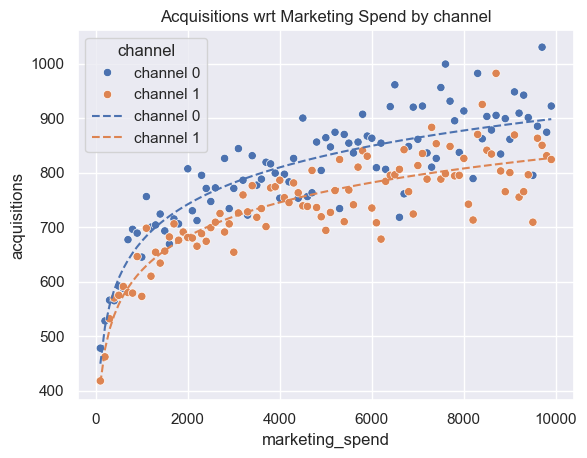

In [3]:
# estimation
models = {}
for c in channels:
    model=fit_log_response_curve(data[data.channel == c], x=x, y=y)
    data.loc[data.channel == c, f'fitted_{y}'] = model.predict(data[data.channel == c])
    models[c]=model

# review estimation
plot_response_curve(data)

# Marketing Spend Optimisation

## Lagrangian Method (Analytical Solution)

In [4]:
# lagrangian method
ltv_0 = data[data.channel == channels[0]].ltv.values[0]
ltv_1 = data[data.channel == channels[1]].ltv.values[0]
b_0 = models[channels[0]].params[f'np.log({x})']
b_1 = models[channels[1]].params[f'np.log({x})']

c_0 = round(budget/(1 + (ltv_1*b_1) / (ltv_0*b_0)), 2)
c_1 = round(budget - c_0, 2)
max_profit = round(b_0*np.log(c_0)*ltv_0 - c_0 + b_1*np.log(c_1)*ltv_1 - c_1, 2)
print('lagrangian optimal spend', c_0, c_1, max_profit)

lagrangian optimal spend 385.27 614.73 18060.73


## Simulation

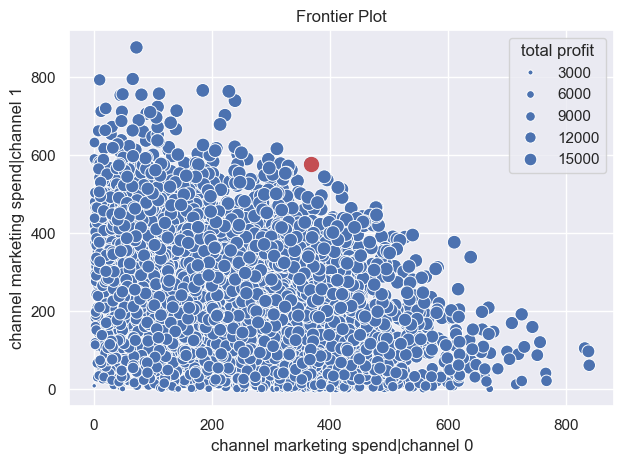

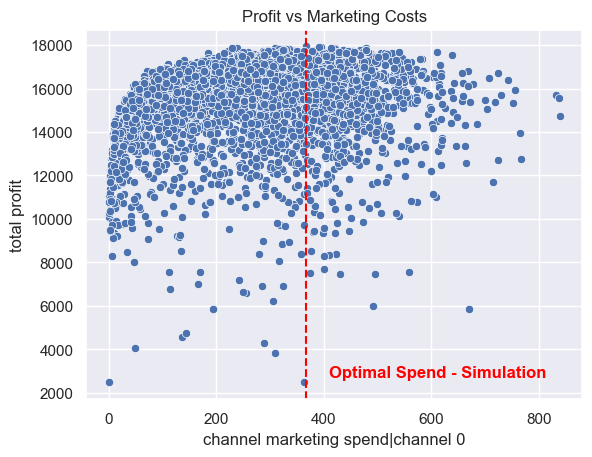

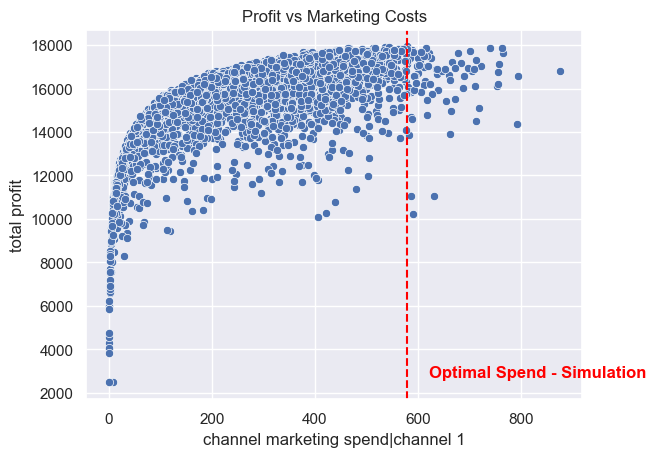

In [6]:
# simulation method
results, report = sim_opt_profit(data, budget, models, x, y)
plot_frontier(results, 
              f"channel marketing spend|{channels[0]}", 
              f"channel marketing spend|{channels[1]}",
              report[f'sim optimal spend|{channels[0]}'],
              report[f'sim optimal spend|{channels[1]}']
              )
for channel in channels:
    optimal_spend = report[f'sim optimal spend|{channel}']
    plot_profit_curve(results, x=f"channel marketing spend|{channel}", y="total profit", optimal_spend=optimal_spend)

In [10]:
pp.pprint(report)

{   'sim max profit': np.float64(17943.58),
    'sim optimal spend|channel 0': np.float64(367.18),
    'sim optimal spend|channel 1': np.float64(578.12)}


## Nonlinear Programming with cvxpy

In [13]:
# nonlinear programming method
results = nonlinear_programming_opt(budget, ltv_0, ltv_1, b_0, b_1)
pp.pprint(results)

{   'c_0': np.float64(385.23),
    'c_1': np.float64(614.77),
    'max profit': np.float64(18060.73)}
